In [43]:
from simulation import *
from config import *
from surfer import *
from wave import *
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
def summarize(res):
    print(f"Wave Count:        {res['wave_counts']}")
    print(f"Number of surfers: {res['n_surfers']}")
    print(f"Success rate:      {res['success_rate']:.2f}")
    print(f"Collision rate:    {res['collision_rate']:.2f}")
    print(f"Waiting:           {res['avg_waiting_time']:.2f}")
    print(f"Fairness:          {res['fairness']:.3f}")

In [47]:
def summary_table(mean, std, label_name="condition"):

    rows = []

    conditions = []
    for key in mean.keys():
        cond = key.replace("_mean", "")
        conditions.append(cond)      

    first_cond = conditions[0]
    metrics = mean[f"{first_cond}_mean"].keys()

    for cond in conditions:
        mean_vals = mean[f"{cond}_mean"]
        std_vals = std[f"{cond}_std"]
    
        for metric in metrics:
            rows.append({
                label_name: cond,
                "metric": metric,
                "mean": mean_vals[metric],
                "std": std_vals[metric]
            })

    return pd.DataFrame(rows)

In [102]:
def run_many(
        number_of_runs=50,
        mode=None,
        spot_level=None,
        rule_type=None,
        num_surfer=None,
        ratio=None,
        spot_conf=None,
        wave_schedule=None,
        duration=None,
):
    """
    Run multiple simulations and return (mean, std) of the results
    """
    if mode is None:
        mode=EXPR_CONF["mode"]
    if spot_level is None:
        spot_level=SPOT_LEVEL
    if rule_type is None:
        rule_type=RULE_TYPE
    if spot_conf is None:
        spot_conf=SPOT_CONF[spot_level]
    if duration is None:
        duration=SESSION_DURATION

    results = []

    for _ in range(number_of_runs):
        res = run_simulation(
            mode=mode,
            spot_level=spot_level,
            rule_type=rule_type,
            num_surfer=num_surfer,
            ratio=ratio if mode == "experiment" else None,
            spot_conf=spot_conf,
            wave_schedule=wave_schedule,
            duration=duration,
        )
        res_metrics = {
            "n_surfers": res["n_surfers"], 
            "wave_counts": res["wave_counts"], 
            "success_rate": res["success_rate"], 
            "collision_rate": res["collision_rate"], 
            "avg_waiting_time": res["avg_waiting_time"],
            "fairness": res["fairness"]
        }
        results.append(res_metrics)

    df = pd.DataFrame(results)
    return results, df.mean(), df.std()

# Validation 📑

Cumulative Average Plot

In [110]:
data, mean, std = run_many(number_of_runs=100, num_surfer=80)

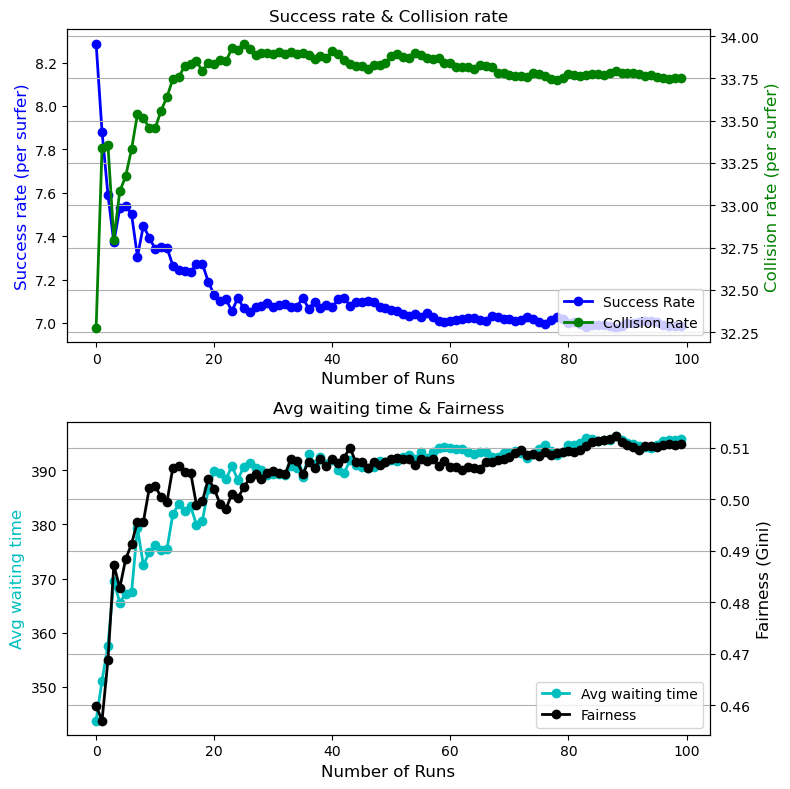

In [129]:
df = pd.DataFrame(data)

# calculate cumulative average
for metric in ['success_rate', 'collision_rate', 'avg_waiting_time', 'fairness']:
    df[metric] = df[metric].expanding().mean()

# plot
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# -- Subplot 1: Success rate & Collision rate --
# plot left Y-axis (Collision rate)
ax1 = axes[0]
ax1.set_title("Success rate & Collision rate")   
ax1.set_xlabel('Number of Runs', fontsize=12)

(line1, ) = ax1.plot(df.index, df['success_rate'], 'b-o', linewidth=2, label='Success Rate')
ax1.set_ylabel('Success rate (per surfer)', fontsize=12, color='b')

ax1r = ax1.twinx()
(line2, ) = ax1r.plot(df.index, df['collision_rate'], 'g-o', linewidth=2, label='Collision Rate')
ax1r.set_ylabel("Collision rate (per surfer)", fontsize=12, color='g')

plt.legend([line1, line2], [line1.get_label(), line2.get_label()], loc="best")
plt.grid()

# -- Subplot 2: Avg waiting time & Fairness --
ax2 = axes[1]
ax2.set_title("Avg waiting time & Fairness")   
ax2.set_xlabel('Number of Runs', fontsize=12)

(line3, ) = ax2.plot(df.index, df['avg_waiting_time'], 'c-o', linewidth=2, label='Avg waiting time')
ax2.set_ylabel('Avg waiting time', fontsize=12, color='c')

ax2r = ax2.twinx()
(line4, ) = ax2r.plot(df.index, df['fairness'], 'k-o', linewidth=2, label='Fairness')
ax2r.set_ylabel("Fairness (Gini)", fontsize=12, color='k')

plt.legend([line3, line4], [line3.get_label(), line4.get_label()], loc="best")
plt.grid()

plt.tight_layout()

plt.show()

### 1. Zero-wave session（0 wave）

This test covers an edge case where the wave schedule is empty, i.e., no waves are generated. Even though surfers are present in the simulation, no riding can occur. As a result, all statistics except for average waiting time should evaluate to zero. With no opportunities to ride, all surfers simply wait until the session ends. Additionally, the absence of competition results in zero fairness.

In [65]:
res = run_many(wave_schedule=[])
summarize(res[0])

Wave Count:        0.0
Number of surfers: 65.76
Success rate:      0.00
Collision rate:    0.00
Waiting:           3600.00
Fairness:          0.000


### 2. Single-surfer session（1 surfer）

This test checks the case where only one surfer is present in the simulation. With no competitors, collisions should never occur, and fairness is naturally zero. The surfer can still ride waves normally, so the success-related statistics should remain valid.

In [62]:
res = run_many(mode="experiment", num_surfer=1, ratio=0)
summarize(res[0])

Wave Count:        2097.74
Number of surfers: 1.0
Success rate:      30.02
Collision rate:    0.00
Waiting:           116.50
Fairness:          0.000


### 3. Zero surfers（empty beach）

This test the case where no surfer exists in the simulation. Even though there are waves during the simulation, no surfer will ride those waves. Accordingly, the statistics related to surfing activity should be zeros.

In [67]:
res = run_many(mode="experiment", num_surfer=0, ratio=0)
summarize(res[0])

Wave Count:        2090.96
Number of surfers: 0.0
Success rate:      0.00
Collision rate:    0.00
Waiting:           0.00
Fairness:          0.000


### 4. Infinite waves (long duration)

This is a stress test to check if the program still works noramlly in some extreme conditions, such as long duration.

In [17]:
results_val4 = []

for dur in [1000, 2000, 5000, 10000, 20000, 40000]:
    res = run_simulation(duration=dur)
    res["session_duration"] = dur
    results_val4.append(res)

In [18]:
df_val4 = pd.DataFrame(results_val4).set_index("session_duration")
df_val4

,spot_level,n_surfers,beginner_ratio,wave_counts,success_rate,collision_rate,avg_waiting_time,fairness
session_duration,,,,,,,,
1000,beginner,59,None,570,2.779661,8.338983,590.756098,0.445019
2000,beginner,71,None,1157,4.816901,18.295775,406.926901,0.489087
5000,beginner,52,None,2969,17.692308,39.384615,236.656522,0.289130
10000,beginner,75,None,5917,21.360000,96.106667,387.645443,0.473208
20000,beginner,74,None,11974,42.175676,181.594595,412.156040,0.505187
40000,beginner,65,None,23449,109.107692,350.369231,355.414270,0.402482


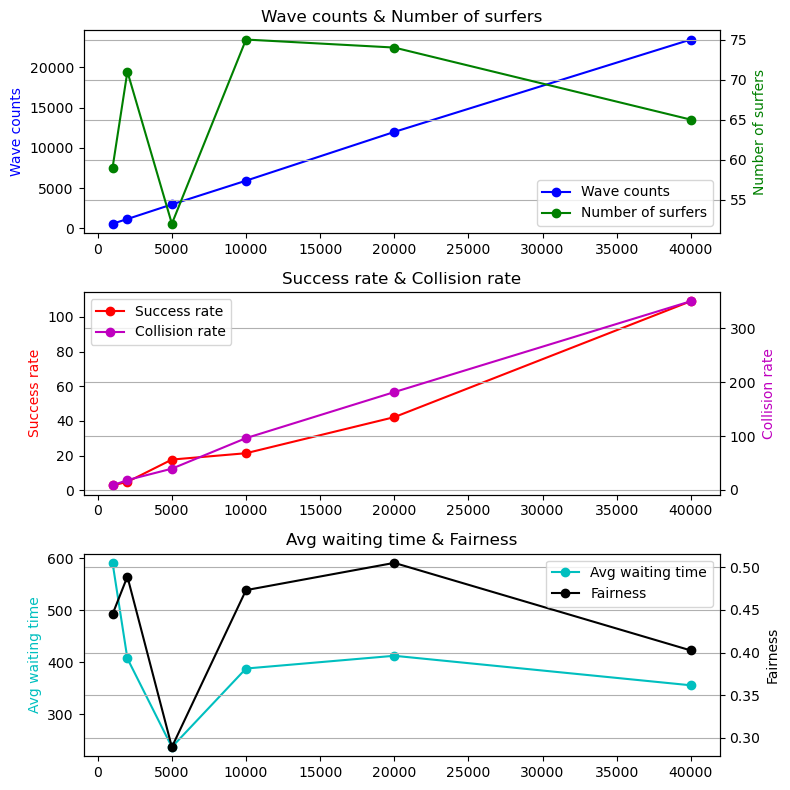

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8))

# -- Subplot 1: Wave counts & Number of surfers --
ax1 = axes[0]
ax1.set_title("Wave counts & Number of surfers")   

(ln1,) = ax1.plot(df_val4.index, df_val4['wave_counts'], 'b-o', label="Wave counts")
ax1.set_ylabel("Wave counts", color='b')

ax1r = ax1.twinx()
(ln2,) = ax1r.plot(df_val4.index, df_val4['n_surfers'], 'g-o', label="Number of surfers")
ax1r.set_ylabel("Number of surfers", color='g')

plt.legend([ln1, ln2], [ln1.get_label(), ln2.get_label()], loc="best")
plt.grid()

# -- Subplot 2: Success rate & Collision rate --
ax2 = axes[1]
ax2.set_title("Success rate & Collision rate")

(ln3, ) = ax2.plot(df_val4.index, df_val4['success_rate'], "r-o", label="Success rate")
ax2.set_ylabel("Success rate", color='r')

ax2r = ax2.twinx()
(ln4,) = ax2r.plot(df_val4.index, df_val4['collision_rate'], 'm-o', label="Collision rate")
ax2r.set_ylabel("Collision rate", color='m')

plt.legend([ln3, ln4], [ln3.get_label(), ln4.get_label()], loc="best")
plt.grid()

# -- Subplot 3: Avg waiting time & Fairness --
ax3 = axes[2]
ax3.set_title("Avg waiting time & Fairness")

(ln5, ) = ax3.plot(df_val4.index, df_val4['avg_waiting_time'], "c-o", label="Avg waiting time")
ax3.set_ylabel("Avg waiting time", color='c')

ax3r = ax3.twinx()
(ln6,) = ax3r.plot(df_val4.index, df_val4['fairness'], 'k-o', label="Fairness")
ax3r.set_ylabel("Fairness", color='k')

plt.legend([ln5, ln6], [ln5.get_label(), ln6.get_label()], loc="best")
plt.grid()

plt.xlabel("Session Duration")
plt.tight_layout()

plt.show()

The average waiting time appears to stabilize as the session duration increases.
These suggest that the system behaves stably over long runs.

## Experiments 🔬

#### Hypothesis 1: When the rule is free-for-all, advanced spots usually run smoother because skilled surfers handle the lineup better. This lowers waiting time and also lowers the Gini score since waves are shared more evenly. Beginner spots are much more chaotic, so waiting time goes up and the Gini score increases as skilled surfers still catch more waves while beginners struggle.

In [23]:
# Fix Poisson λ for wave counts
import copy

beg_conf = copy.deepcopy(SPOT_CONF["beginner"])
mix_conf = copy.deepcopy(SPOT_CONF["mixed"])
adv_conf = copy.deepcopy(SPOT_CONF["advanced"])

fixed_lambda = 4.5

beg_conf["lambda_set"] = fixed_lambda
mix_conf["lambda_set"] = fixed_lambda
adv_conf["lambda_set"] = fixed_lambda

# Run for three different spot levels
mean_beg, std_beg = run_many(num_surfer=80, spot_conf = beg_conf, spot_level="beginner")
mean_mix, std_mix = run_many(num_surfer=80, spot_conf = mix_conf, spot_level="mixed")
mean_adv, std_adv = run_many(num_surfer=80, spot_conf = adv_conf, spot_level="advanced")

mean = {
    "beg_mean": mean_beg,
    "mix_mean": mean_mix,
    "adv_mean": mean_adv
}

std = {
    "beg_std": std_beg,
    "mix_std": std_mix,
    "adv_std": std_adv
}

df_level = summary_table(mean, std, label_name="spot_level")
df_level["rule_type"] = "free-for-all"
df_level = df_level.set_index(["rule_type", "spot_level", "metric"])
print(df_level.round(3))

                                              mean     std
rule_type    spot_level metric                            
free-for-all beg        n_surfers           80.000   0.000
                        wave_counts       2683.960  96.311
                        success_rate         7.721   0.714
                        collision_rate      35.630   0.792
                        avg_waiting_time   356.539  36.751
                        fairness             0.495   0.043
             mix        n_surfers           80.000   0.000
                        wave_counts       2705.320  81.608
                        success_rate        14.344   0.839
                        collision_rate      29.793   0.556
                        avg_waiting_time   212.445   9.673
                        fairness             0.276   0.027
             adv        n_surfers           80.000   0.000
                        wave_counts       2694.460  96.747
                        success_rate        17.637   0.5

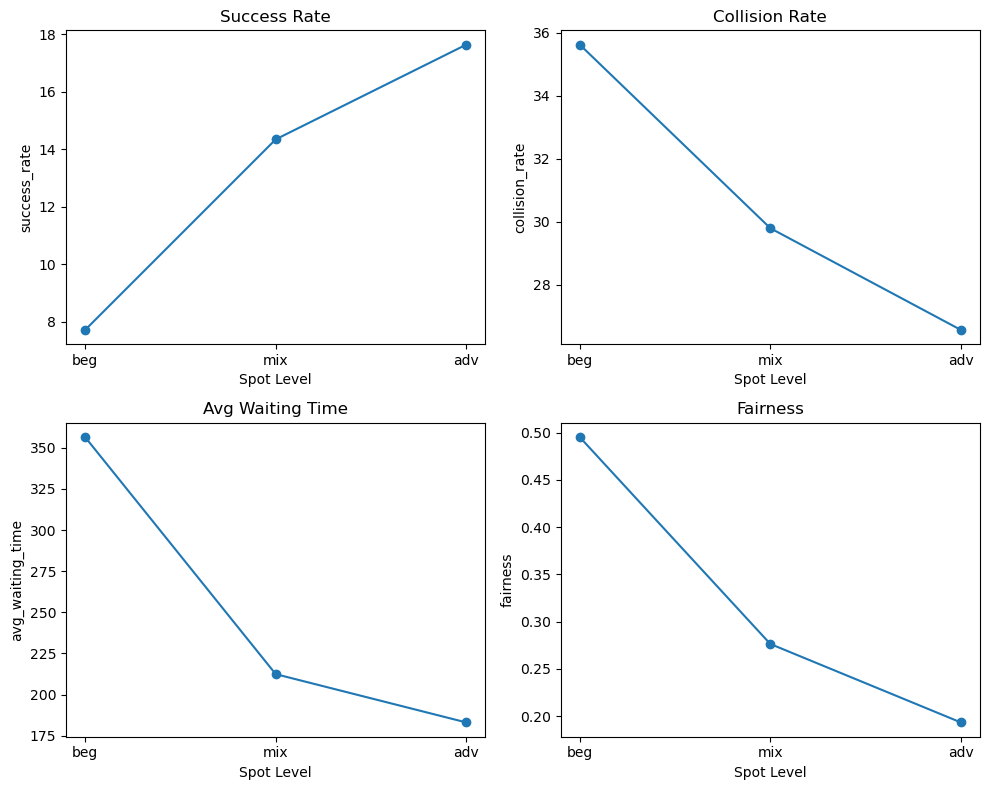

In [24]:
# AI matplotlib assistance

import matplotlib.pyplot as plt

metrics = ["success_rate", "collision_rate", "avg_waiting_time", "fairness"]
spot_levels = ["beg", "mix", "adv"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]

    values = []
    for spot in spot_levels:
        values.append(df_level.loc[("free-for-all", spot, metric), "mean"])

    ax.plot(spot_levels, values, marker='o')
    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("Spot Level")
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()

#### Hypothesis 2: Under the same spot level (L), the “first-in-line” rule leads to at least 20% lower Gini and 30% fewer collisions than the “free-for-all” rule.

In [26]:
dataframes = []

for level in ["beginner", "mixed", "advanced"]:
    # run for both rule types
    mean_free, std_free = run_many(rule_type="free_for_all", num_surfer=80, spot_level=level)
    mean_first, std_first = run_many(rule_type="safe_distance", num_surfer=80, spot_level=level)
    
    mean = {
        "free_mean": mean_free,
        "safe_mean": mean_first
    }
    
    std = {
        "free_std": std_free,
        "safe_std": std_first
    }

    df = summary_table(mean, std, label_name="rule_type")
    df["spot_level"] = level
    dataframes.append(df)

In [27]:
# total summary table
h2_all_tables = pd.concat(dataframes)
h2_all_tables = h2_all_tables.set_index(["spot_level", "rule_type", "metric"])
print(h2_all_tables.round(3))

                                           mean      std
spot_level rule_type metric                             
beginner   free      n_surfers           80.000    0.000
                     wave_counts       2090.940   73.228
                     success_rate         6.949    0.721
                     collision_rate      33.875    0.947
                     avg_waiting_time   398.850   46.562
                     fairness             0.511    0.039
           safe      n_surfers           80.000    0.000
                     wave_counts       2082.160   84.625
                     success_rate         6.189    0.816
                     collision_rate      31.980    0.938
                     avg_waiting_time   461.531   64.386
                     fairness             0.551    0.044
mixed      free      n_surfers           80.000    0.000
                     wave_counts       2699.140   97.834
                     success_rate        14.537    0.725
                     collision_

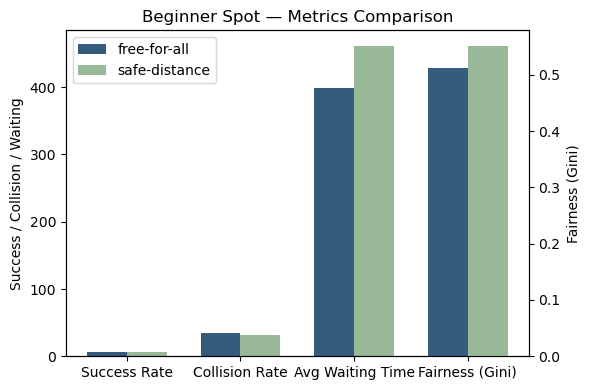

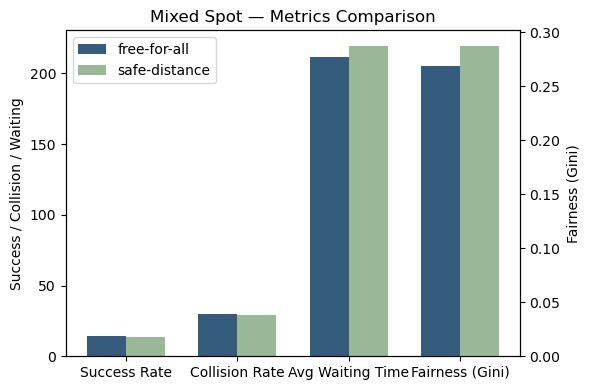

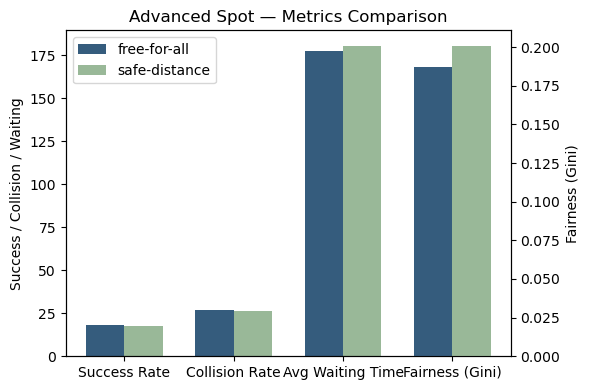

In [28]:
# AI matplotlib assistance

import matplotlib.pyplot as plt
import numpy as np

metrics = ["success_rate", "collision_rate", "avg_waiting_time", "fairness"]
metric_titles = ["Success Rate", "Collision Rate", "Avg Waiting Time", "Fairness (Gini)"]
spot_levels = ["beginner", "mixed", "advanced"]

rule_labels = {"free": "free-for-all", "safe": "safe-distance"}
colors = ["#355C7D", "#99B898"]


for level in spot_levels:
    fig, ax_left = plt.subplots(figsize=(6, 4))
    
    # secondary axis for fairness
    ax_right = ax_left.twinx()  

    x = np.arange(len(metrics))
    bar_width = 0.35

    # extract values
    free_vals = [h2_all_tables.loc[(level, "free", m), "mean"] for m in metrics]
    first_vals = [h2_all_tables.loc[(level, "safe", m), "mean"] for m in metrics]

    # split metrics: fairness goes to right axis
    fairness_idx = metrics.index("fairness")

    # left-axis metrics masks
    left_idx = [i for i in range(len(metrics)) if i != fairness_idx]

    # --- draw left-axis bars ---
    ax_left.bar(x[left_idx] - bar_width/2,
                [free_vals[i] for i in left_idx],
                bar_width, label=rule_labels["free"],
                color=colors[0])

    ax_left.bar(x[left_idx] + bar_width/2,
                [first_vals[i] for i in left_idx],
                bar_width, label=rule_labels["safe"],
                color=colors[1])

    # --- draw right-axis bars for fairness only ---
    ax_right.bar(x[fairness_idx] - bar_width/2,
                 free_vals[fairness_idx],
                 bar_width, color=colors[0])

    ax_right.bar(x[fairness_idx] + bar_width/2,
                 first_vals[fairness_idx],
                 bar_width, color=colors[1])

    # labels / formatting
    ax_left.set_xticks(x)
    ax_left.set_xticklabels(metric_titles)
    ax_left.set_title(f"{level.capitalize()} Spot — Metrics Comparison")

    ax_left.set_ylabel("Success / Collision / Waiting")
    ax_right.set_ylabel("Fairness (Gini)")

    # legend only from left axis
    ax_left.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

#### Hypothesis 3: Higher wave heights will reduce the number of collisions, even when there is a high percentage of beginners.

Having more beginners usually leads to more collisions due to poor control. However, I hypothesize that when waves are significantly bigger, the difficulty acts as a natural filter. Since beginners will likely wipe out or fail to catch the wave early on, fewer unskilled surfers actually make it onto the wave, leading to fewer collisions than expected.

In [31]:
def run_h3_experiment(spot_level, ratios, base, wave50):
    dfs = []
    for ratio in ratios:
        mean_base, std_base = run_many(mode="experiment", ratio=ratio, spot_conf=base, spot_level=spot_level)
        mean_wave50, std_wave50 = run_many(mode="experiment", ratio=ratio, spot_conf=wave50, spot_level=spot_level)
        
        mean = {
            "base_mean": mean_base,
            "wave50_mean": mean_wave50
        }
        
        std = {
            "base_std": std_base,
            "wave50_std": std_wave50
        }
    
        df = summary_table(mean, std, label_name="wave_height")
        df["beg_ratio"] = int(ratio * 100)
        df["spot_level"] = spot_level
        dfs.append(df)
    return pd.concat(dfs)

In [32]:
import copy

# baseline config
base_beg = SPOT_CONF["beginner"]
base_mix = SPOT_CONF["mixed"]
base_adv = SPOT_CONF["advanced"]

# wave-enhanced config
wave50_beg = copy.deepcopy(base_beg)
wave50_beg["wave_height"]["mu"] *= 1.5
wave50_beg["wave_height"]["max"] += 2.0

wave50_mix = copy.deepcopy(base_mix)
wave50_mix["wave_height"]["mu"] *= 1.5
wave50_mix["wave_height"]["max"] += 2.0

wave50_adv = copy.deepcopy(base_adv)
wave50_adv["wave_height"]["mu"] *= 1.5
wave50_adv["wave_height"]["max"] += 2.0

ratios = [0, 0.2, 0.4, 0.6, 0.8]

h3_beginner = run_h3_experiment("beginner", ratios, base_beg, wave50_beg)
h3_mixed = run_h3_experiment("mixed", ratios, base_mix, wave50_mix)
h3_advanced = run_h3_experiment("advanced", ratios, base_adv, wave50_adv)

KeyboardInterrupt: 

In [ ]:
# total summary table
h3_all_tables = pd.concat([h3_beginner, h3_mixed, h3_advanced])
h3_all_tables = h3_all_tables.set_index(["spot_level", "beg_ratio", "metric"])
print(h3_all_tables)

In [ ]:
import matplotlib.pyplot as plt

spot_levels = ["beginner", "mixed", "advanced"]
metrics = ["success_rate", "collision_rate", "fairness", "avg_waiting_time"]
titles = ["Success Rate", "Collision Rate", "Fairness (Gini)", "Avg Waiting Time"]
ratios = [0, 20, 40, 60, 80]

fig, axes = plt.subplots(
    nrows=3,
    ncols=4,
    figsize=(22, 12),
    sharey="col"
)

for row, spot in enumerate(spot_levels):
    for col, metric in enumerate(metrics):
        ax = axes[row, col]

        base_vals = []
        wave50_vals = []

        for r in ratios:
            df_row = h3_all_tables.loc[(spot, r, metric)]

            base_vals.append(
                df_row.loc[df_row["wave_height"] == "base", "mean"].iloc[0]
            )
            wave50_vals.append(
                df_row.loc[df_row["wave_height"] == "wave50", "mean"].iloc[0]
            )

        ax.plot(ratios, base_vals, marker="o", color="#99B898", label="Base")
        ax.plot(ratios, wave50_vals, marker="o", color="#355C7D", label="Wave +50%")

        if row == 0:
            ax.set_title(titles[col])

        if col == 0:
            ax.set_ylabel(spot.capitalize())

        ax.set_xticks(ratios)

        if row == 2:
            ax.set_xlabel("Beginner Ratio (%)")

        if row == 0 and col == 3:
            ax.legend()

plt.tight_layout()
plt.show()


**Analysis**: <br> 
The simulation results strongly support the hypothesis.
1. Primary Observation: As predicted, increasing the wave height resulted in a consistent decrease in collision rates across all spot levels. Two specific trends further validate the "skill filter" mechanism:
   - Impact of Beginner Ratio: The downward trend in collisions becomes more pronounced as the beginner ratio increases. This confirms that high waves effectively prevent the specific group (beginners) most likely to cause collisions from entering the wave face.
   - Impact of Spot Level: As the spot level difficulty increases, the gap in collision rates between normal and high waves widens. This indicate that the filtering effect is amplified in harder environments.
2. Seconday Metrics: Other metrics-such as the decrease in Success Rate, and the increase in the Gini Value and Average Waiting time-showed reasonable behaviors consistent with tougher surfing conditions. Similar to the collision rate, these metrics also showed greater sensitivity to wave height changes as the spot level difficulty increased.

# ---------------------------------------------------------------------------------

Test case

In [ ]:
results = []

for ratio in [0, 0.2, 0.4, 0.6, 0.8]:
    res = run_simulation(mode="experiment", ratio=ratio, spot_conf=wave50, spot_level="mixed")
    results.append(res)
    
df = pd.DataFrame(results)
df

In [ ]:
results = []

for ratio in [0, 0.2, 0.4, 0.6, 0.8]:
    res = run_simulation(mode="experiment", ratio=ratio, spot_level="advanced")
    results.append(res)
    
df = pd.DataFrame(results)
df

In [ ]:
results = []

for type in ['free_for_all', 'safe_distance']:
    res = run_simulation(rule_type=type, num_surfer=80, spot_level="beginner")
    results.append(res)
    
df = pd.DataFrame(results)
df

In [ ]:
results = []

for type in ['free_for_all', 'safe_distance']:
    res = run_simulation(rule_type=type, num_surfer=80, spot_level="mixed")
    results.append(res)
    
df = pd.DataFrame(results)
df

In [ ]:
results = []

for type in ['free_for_all', 'safe_distance']:
    res = run_simulation(rule_type=type, num_surfer=80, spot_level="advanced")
    results.append(res)
    
df = pd.DataFrame(results)
df

In [ ]:
results = []

for level in ["beginner", "mixed", "advanced"]:
    res = run_simulation(mode="realistic", spot_conf=SPOT_CONF[level], spot_level=level, num_surfer=80)
    results.append(res)
    
df = pd.DataFrame(results)
df

In [ ]:
# Run for both rule types
mean_free, std_free = run_many(rule_type="free_for_all", num_surfer=80, spot_level="advanced")
mean_first, std_first = run_many(rule_type="safe_distance", num_surfer=80, spot_level="advanced")

# # Compare metrics
# collision_drop = 1 - mean_first["collision_rate"] / mean_free["collision_rate"]
# gini_drop      = 1 - mean_first["fairness"] / mean_free["fairness"]

mean = {
    "free_mean": mean_free,
    "safe_mean": mean_first
}

std = {
    "free_std": std_free,
    "safe_std": std_first
}

df_adv = summary_table(mean, std, label_name="rule_type")
df_adv = df_adv.set_index(["rule_type", "metric"])
print(df_adv)